Training Data Shape: (517754, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


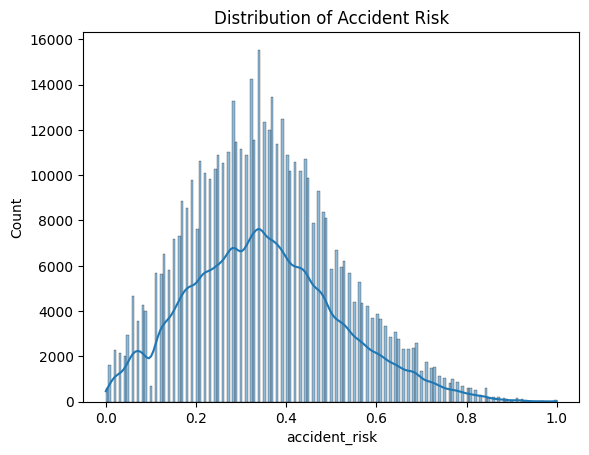

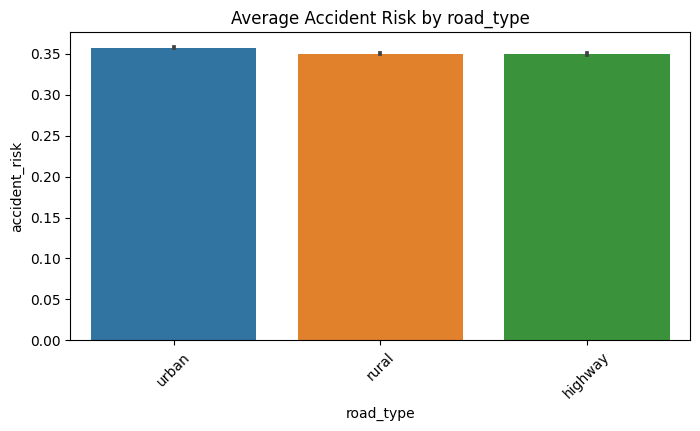

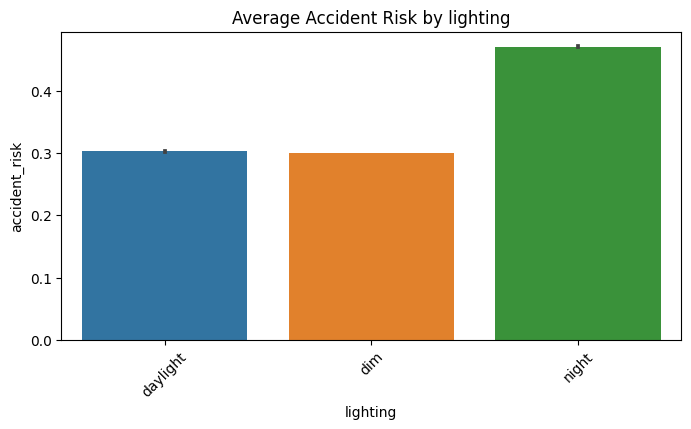

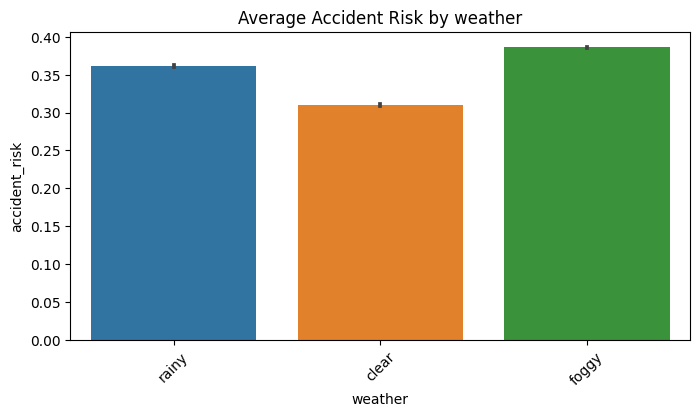

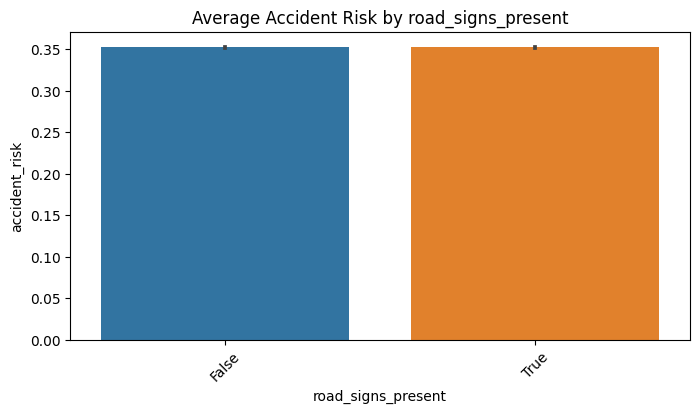

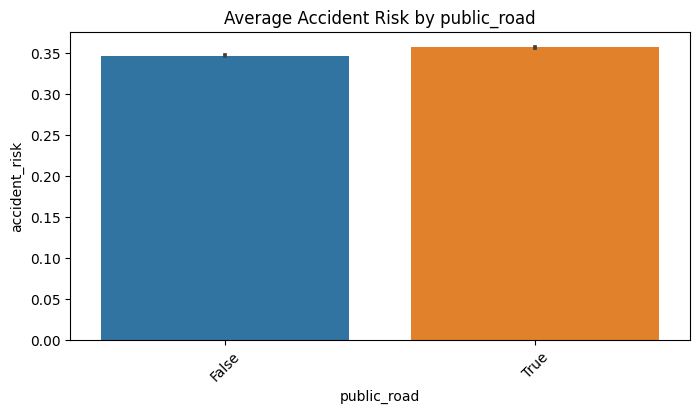

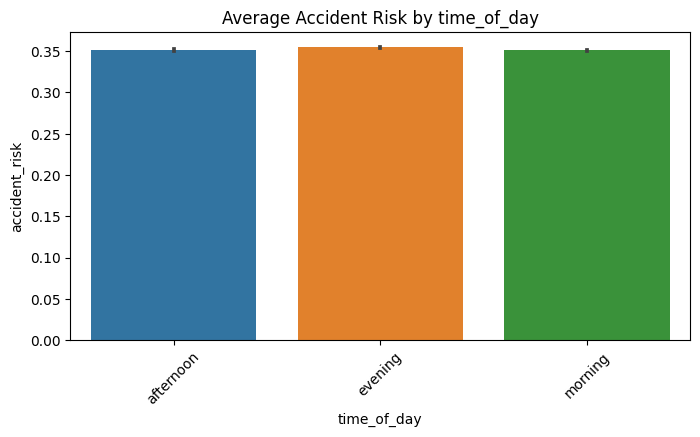

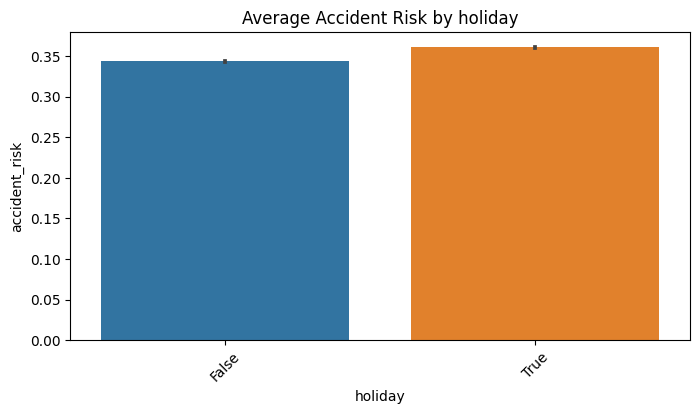

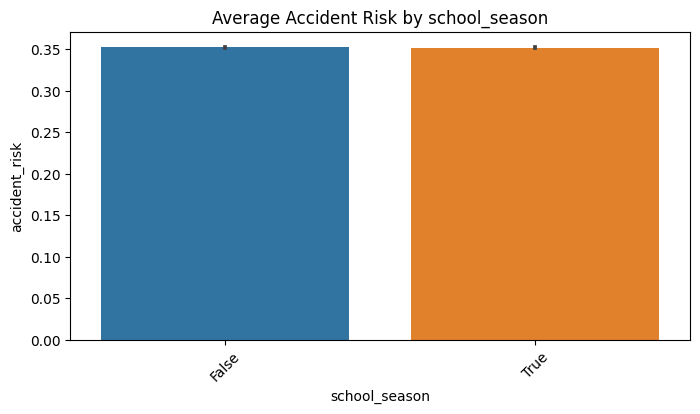

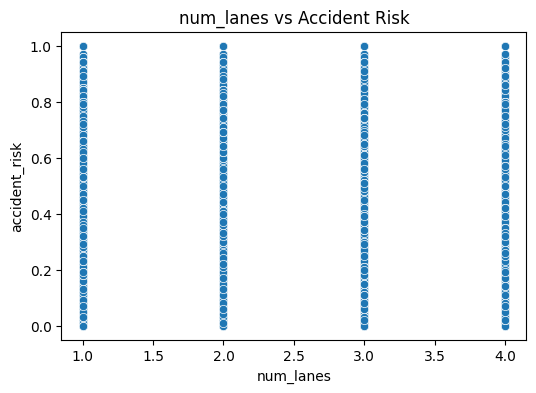

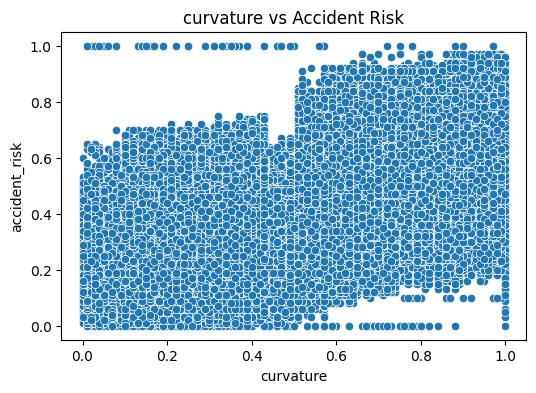

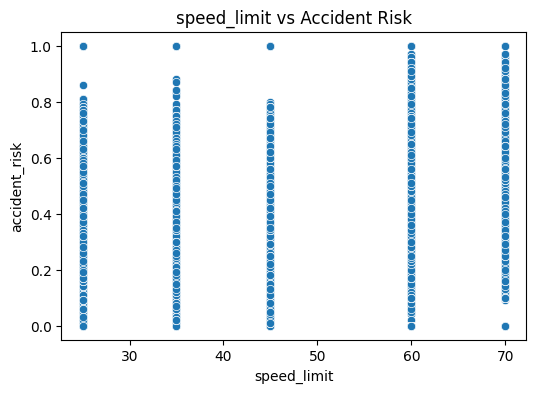

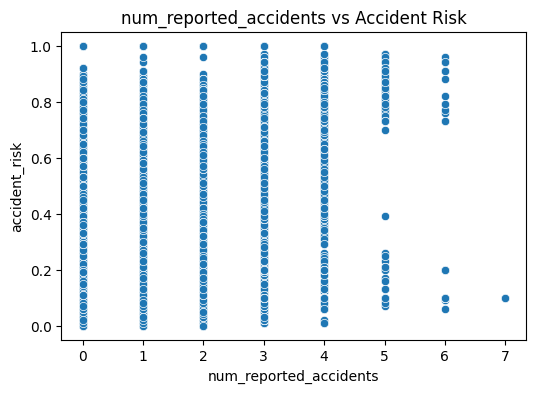

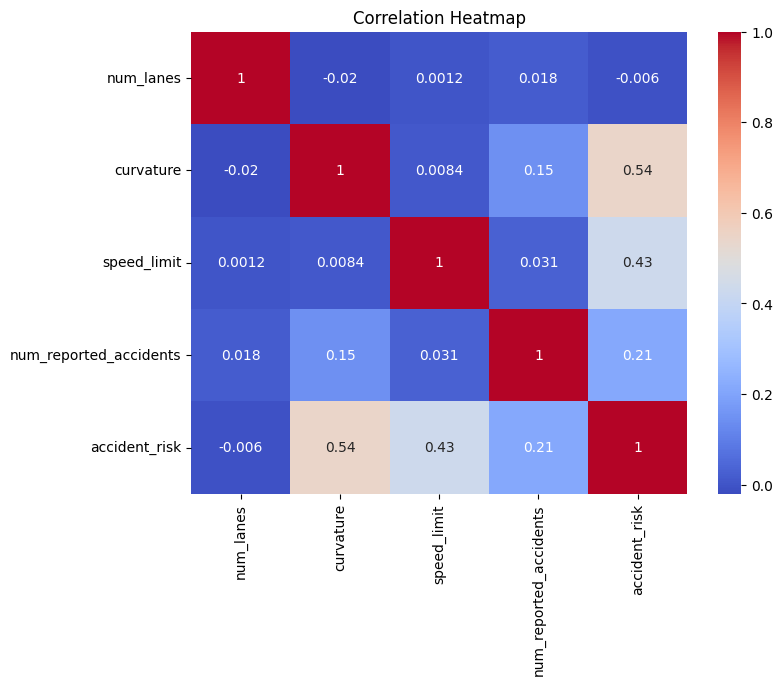

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       517754 non-null  int64  
 1   num_lanes                517754 non-null  int64  
 2   curvature                517754 non-null  float64
 3   speed_limit              517754 non-null  int64  
 4   num_reported_accidents   517754 non-null  int64  
 5   accident_risk            517754 non-null  float64
 6   road_type_rural          517754 non-null  int64  
 7   road_type_urban          517754 non-null  int64  
 8   lighting_dim             517754 non-null  int64  
 9   lighting_night           517754 non-null  int64  
 10  weather_foggy            517754 non-null  int64  
 11  weather_rainy            517754 non-null  int64  
 12  road_signs_present_True  517754 non-null  int64  
 13  public_road_True         517754 non-null  int64  
 14  time

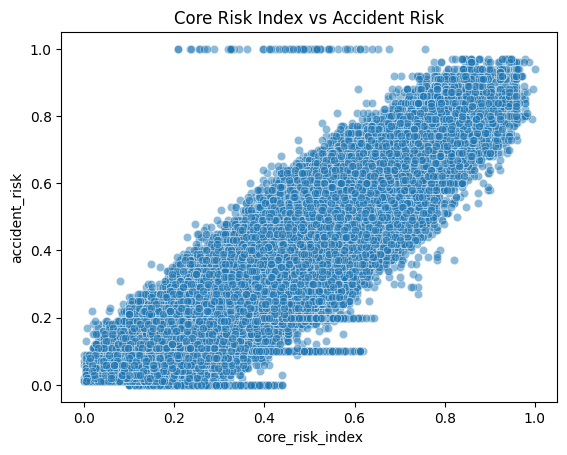

New R² score: 0.8893
New RMSE: 0.055377


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")

print("Training Data Shape:", train.shape)
train.info()
train.isnull().sum()

sns.histplot(train['accident_risk'], kde=True)
plt.title('Distribution of Accident Risk')
plt.show()


cat_features = ['road_type', 'lighting', 'weather', 'road_signs_present',
                'public_road', 'time_of_day', 'holiday', 'school_season']

for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='accident_risk', data=train, estimator=np.mean)
    plt.title(f'Average Accident Risk by {col}')
    plt.xticks(rotation=45)
    plt.show()


numerical = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

for col in numerical:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='accident_risk', data=train)
    plt.title(f'{col} vs Accident Risk')
    plt.show()

corr = train[numerical + ['accident_risk']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

for col in cat_features:
    train[col] = train[col].astype(str)

train_encoded = pd.get_dummies(train, columns=cat_features, drop_first=True)

bool_cols = train_encoded.select_dtypes(include='bool').columns
train_encoded[bool_cols] = train_encoded[bool_cols].astype(int)
train_encoded.info()

def create_advanced_features(df):
    df = df.copy()
    
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)
    
    df['speed_curvature_ratio'] = df['speed_limit'] / (df['curvature'] + 1)
    df['lanes_per_accident'] = df['num_lanes'] / (df['num_reported_accidents'] + 1)
    df['speed_curvature_tension'] = df['speed_limit'] * df['curvature']
    
    df['risky_weather'] = 0
    if 'weather_rainy' in df.columns and 'weather_foggy' in df.columns:
        df['risky_weather'] = ((df['weather_rainy'] == 1) | (df['weather_foggy'] == 1)).astype(int)
    
    df['night_and_dim'] = 0
    if 'lighting_night' in df.columns and 'lighting_dim' in df.columns:
        df['night_and_dim'] = ((df['lighting_night'] == 1) | (df['lighting_dim'] == 1)).astype(int)
    
    df['danger_score'] = 0
    if 'curvature' in df.columns:
        df['danger_score'] += df['curvature'] * 0.5
    if 'weather_rainy' in df.columns:
        df['danger_score'] += df['weather_rainy'] * 0.7
    if 'weather_foggy' in df.columns:
        df['danger_score'] += df['weather_foggy'] * 0.8
    if 'lighting_night' in df.columns:
        df['danger_score'] += df['lighting_night'] * 0.9
    if 'lighting_dim' in df.columns:
        df['danger_score'] += df['lighting_dim'] * 0.6
    if 'speed_limit' in df.columns:
        df['danger_score'] += (df['speed_limit'] / 120) * 0.4
    
    df['driver_stress_index'] = 0
    if 'road_type_urban' in df.columns:
        df['driver_stress_index'] += df['road_type_urban'] * 1.0
    if 'curvature' in df.columns:
        df['driver_stress_index'] += df['curvature'] * 0.4
    if 'num_lanes' in df.columns:
        df['driver_stress_index'] += ((df['num_lanes'] > 3).astype(int)) * 0.3
    if 'risky_weather' in df.columns:
        df['driver_stress_index'] += df['risky_weather'] * 0.5
    if 'time_of_day_evening' in df.columns:
        df['driver_stress_index'] += df['time_of_day_evening'] * 0.4

    df['visibility_impact'] = 0
    for col, weight in [('lighting_night',1.0), ('lighting_dim',0.7), ('weather_foggy',0.8), ('weather_rainy',0.6)]:
        if col in df.columns:
            df['visibility_impact'] += df[col] * weight
    
    df['rush_hour_flag'] = 0
    if all(c in df.columns for c in ['road_type_urban','time_of_day_morning','time_of_day_evening','school_season_True']):
        df['rush_hour_flag'] = ((df['road_type_urban']==1) &
                                ((df['time_of_day_morning']==1) | (df['time_of_day_evening']==1)) &
                                (df['school_season_True']==1)).astype(int)
    
    df['design_flaw_score'] = 0
    if 'num_lanes' in df.columns:
        df['design_flaw_score'] += ((df['num_lanes']>3).astype(int)*0.5)
    if 'curvature' in df.columns:
        df['design_flaw_score'] += ((df['curvature']>0.7).astype(int)*0.3)
    if 'num_reported_accidents' in df.columns and 'num_lanes' in df.columns:
        df['design_flaw_score'] += ((df['num_reported_accidents']>df['num_lanes']).astype(int)*0.7)

    df['school_zone_risk'] = 0
    if all(c in df.columns for c in ['school_season_True','time_of_day_morning','public_road_True']):
        df['school_zone_risk'] = ((df['school_season_True']==1) & 
                                  (df['time_of_day_morning']==1) & 
                                  (df['public_road_True']==1)).astype(int)
    
    if 'num_reported_accidents' in df.columns and 'num_lanes' in df.columns:
        df['accidents_per_lane'] = df['num_reported_accidents'] / (df['num_lanes']+1)
    
    df['holiday_behavior_risk'] = 0
    if 'holiday_True' in df.columns:
        df['holiday_behavior_risk'] = df['holiday_True']
        if 'lighting_night' in df.columns:
            df['holiday_behavior_risk'] *= df['lighting_night']
        if 'weather_foggy' in df.columns:
            df['holiday_behavior_risk'] += df['weather_foggy']
    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)
    
    return df

train_features = create_advanced_features(train_encoded)

columns_to_drop = [
    'curvature', 'speed_limit', 'lighting_night', 'lighting_dim',
    'weather_rainy', 'weather_foggy', 'road_type_urban', 'road_type_rural',
    'num_lanes', 'num_reported_accidents',
    'time_of_day_evening', 'time_of_day_morning',
    'school_season_True', 'public_road_True'
]
train_features_clean = train_features.drop(columns=columns_to_drop)

X = train_features_clean.drop('accident_risk', axis=1)
y = train_features_clean['accident_risk']

test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

for col in cat_features:
    test[col] = test[col].astype(str)
test_encoded = pd.get_dummies(test, columns=cat_features, drop_first=True)

bool_cols = test_encoded.select_dtypes(include='bool').columns
test_encoded[bool_cols] = test_encoded[bool_cols].astype(int)

test_features = create_advanced_features(test_encoded)

test_features_clean = test_features.drop(columns=columns_to_drop, errors='ignore')

missing_cols = set(X.columns) - set(test_features_clean.columns)
for col in missing_cols:
    test_features_clean[col] = 0
test_features_clean = test_features_clean[X.columns]

print("Test features ready:", test_features_clean.shape)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("R2 score:", r2_score(y_val, y_pred))
print("RMSE:", mean_squared_error(y_val, y_pred, squared=False))

test_predictions = model.predict(test_features_clean)

submission = pd.DataFrame({
    'id': test['id'],
    'accident_risk': test_predictions
})
#top signifincant faetures 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np

X = train_features_clean.drop('accident_risk', axis=1)
y = train_features_clean['accident_risk']

X_const = sm.add_constant(X) 
model = sm.OLS(y, X_const).fit()

print(model.summary())

significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()

if 'const' in significant_features:
    significant_features.remove('const')

print("Significant Predictors:", significant_features)

X_selected = X[significant_features]

import statsmodels.api as sm
import pandas as pd

# Separate target and features
X_raw = train_encoded.drop('accident_risk', axis=1)
y_raw = train_encoded['accident_risk']

X_raw_const = sm.add_constant(X_raw)

ols_model = sm.OLS(y_raw, X_raw_const).fit()

print(ols_model.summary())

significant_raw = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
if 'const' in significant_raw:
    significant_raw.remove('const')

coeffs = ols_model.params[significant_raw].abs().sort_values(ascending=False)

train_encoded['core_risk_index'] = (
    0.32 * train_encoded['curvature'] +
    0.18 * train_encoded['lighting_night'] +
    0.09 * train_encoded['weather_rainy'] +
    0.09 * train_encoded['weather_foggy'] +
    0.02 * train_encoded['num_reported_accidents'] +
    0.005 * train_encoded['speed_limit']
)


train_encoded['core_risk_index'] = (
    (train_encoded['core_risk_index'] - train_encoded['core_risk_index'].min()) /
    (train_encoded['core_risk_index'].max() - train_encoded['core_risk_index'].min())
)


import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='core_risk_index', y='accident_risk', data=train_encoded, alpha=0.5)
plt.title('Core Risk Index vs Accident Risk')
plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

train_encoded['core_risk_index'] = (
    0.32 * train_encoded['curvature'] +
    0.18 * train_encoded['lighting_night'] +
    0.09 * train_encoded['weather_rainy'] +
    0.09 * train_encoded['weather_foggy'] +
    0.02 * train_encoded['num_reported_accidents'] +
    0.005 * train_encoded['speed_limit']
)

train_encoded['core_risk_index'] = (
    (train_encoded['core_risk_index'] - train_encoded['core_risk_index'].min()) /
    (train_encoded['core_risk_index'].max() - train_encoded['core_risk_index'].min())
)

test_encoded['core_risk_index'] = (
    0.32 * test_encoded['curvature'] +
    0.18 * test_encoded['lighting_night'] +
    0.09 * test_encoded['weather_rainy'] +
    0.09 * test_encoded['weather_foggy'] +
    0.02 * test_encoded['num_reported_accidents'] +
    0.005 * test_encoded['speed_limit']
)

test_encoded['core_risk_index'] = (
    (test_encoded['core_risk_index'] - test_encoded['core_risk_index'].min()) /
    (test_encoded['core_risk_index'].max() - test_encoded['core_risk_index'].min())
)


X = train_encoded.drop(columns=['accident_risk'])
y = train_encoded['accident_risk']

X_test = test_encoded[X.columns.intersection(test_encoded.columns)]
xgb_model_new = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

xgb_model_new.fit(X, y)

y_pred_train = xgb_model_new.predict(X)
r2 = r2_score(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print(f"New R² score: {r2:.4f}")
print(f"New RMSE: {rmse:.6f}")

y_test_pred = xgb_model_new.predict(X_test)

output = pd.DataFrame({
    'id': test['id'],
    'predicted_accident_risk': y_test_pred
})

output.head()
output.to_csv("/kaggle/working/submission.csv", index=False)